# Import Necessary Libraries

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
# to see execution time of each cell

!pip install ipython-autotime

%load_ext autotime

time: 363 µs (started: 2024-03-21 07:57:53 +00:00)


In [ ]:
torch.cuda.is_available()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0
time: 57.7 ms (started: 2024-03-21 07:57:53 +00:00)


# Load and normalize CIFAR10




In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 54630108.60it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
time: 7.04 s (started: 2024-03-21 07:57:53 +00:00)


# Define a Convolutional Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding='same')
        self.act1 = nn.ReLU()
        # self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=1, padding='same')
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3,3), stride=1, padding='same')
        self.act3 = nn.ReLU()

        self.pool3 = nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2))

        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(128*16*16, 1024)
        self.act_fc1 = nn.ReLU()
        # self.drop3 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(1024, 512)
        self.act_fc2 = nn.ReLU()

        self.fc3 = nn.Linear(512, 10)

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        # x = self.drop1(x)
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.pool3(x)
        x = self.flat(x)
        x = self.act_fc1(self.fc1(x))
        # x = self.drop3(x)
        x = self.act_fc2(self.fc2(x))
        x = self.fc3(x)
        x = self.logsoftmax(x)
        return x

model = Model().to(device)

time: 660 ms (started: 2024-03-21 07:58:00 +00:00)


In [ ]:
!pip install torchsummary
from torchsummary import summary
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
           Flatten-8                [-1, 32768]               0
            Linear-9                 [-1, 1024]      33,555,456
             ReLU-10                 [-1, 1024]               0
           Linear-11                  [-1, 512]         524,800
             ReLU-12                  [-1, 512]               0
           Linear-13                   [-1, 10]           5,130
       LogSoftmax-14                   

In [ ]:
import torch.nn.init as init
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        # Apply Xavier initialization to weights
        init.xavier_uniform_(m.weight)
        # Initialize biases to zeros
        if m.bias is not None:
            init.constant_(m.bias, 0.0)

time: 898 µs (started: 2024-03-21 07:58:16 +00:00)


# Train the network

In [ ]:
def train(n_epochs,trainloader,model,loss_fn,optimizer):
    losses = []
    epoch_no=[]
    num_batches = len(trainloader)
    for epoch in range(n_epochs):
        # for inputs, labels in trainloader:
        running_loss = 0.0
        epoch_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # forward, backward, and then weight update
            inputs, labels = data[0].to(device), data[1].to(device)
            # inputs = inputs.to(device)
            # labels = labels.to(device)

            y_pred = model(inputs)
            loss = loss_fn(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            running_loss += loss.item()
            if i % 200 == 199:    # print every 2000 mini-batches
                print(f'[{epoch}, {i + 1:5d}] loss: {running_loss}')
                running_loss = 0.0
        print("------------------------------------------------------------------------")
        losses.append(epoch_loss*100/num_batches)
        epoch_no.append(epoch)
    return losses,epoch_no


time: 1.85 ms (started: 2024-03-21 07:58:16 +00:00)


In [ ]:
from datetime import datetime
import torch.optim as optim
import matplotlib.pyplot as plt

n_epochs = 100
model = Model()
model.apply(weights_init)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

start = datetime.now()
SGD_momen,epoch_no =  train(n_epochs,trainloader,model,loss_fn,optimizer)
end = datetime.now()

# find difference loop start and end time and display
td = (end - start).total_seconds()
print(f"The time of execution of above program is : {td:.03f}s")



[0,   200] loss: 423.3274439573288
[0,   400] loss: 365.2574887275696
[0,   600] loss: 345.43982219696045
[0,   800] loss: 325.71404325962067
[0,  1000] loss: 308.4866645336151
[0,  1200] loss: 291.81265664100647
[0,  1400] loss: 284.3230082988739
------------------------------------------------------------------------
[1,   200] loss: 262.0020089149475
[1,   400] loss: 255.97041130065918
[1,   600] loss: 250.03443908691406
[1,   800] loss: 245.40851259231567
[1,  1000] loss: 241.49216675758362
[1,  1200] loss: 237.90731662511826
[1,  1400] loss: 237.1879279613495
------------------------------------------------------------------------
[2,   200] loss: 212.4361451268196
[2,   400] loss: 215.23692846298218
[2,   600] loss: 207.47887831926346
[2,   800] loss: 202.44436597824097
[2,  1000] loss: 200.0954201221466
[2,  1200] loss: 201.78921049833298
[2,  1400] loss: 198.3449774980545
------------------------------------------------------------------------
[3,   200] loss: 172.3004330694675

In [ ]:
acc = 0
count = 0
for inputs, labels in testloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    y_pred = model(inputs)
    acc += (torch.argmax(y_pred, 1) == labels).float().sum()
    count += len(labels)
acc /= count
print("model accuracy",acc*100)

model accuracy tensor(71.9200, device='cuda:0')
time: 3.03 s (started: 2024-03-21 08:25:39 +00:00)


#  SGD optimizer without momentum

In [ ]:
n_epochs = 100
model = Model()
model.apply(weights_init)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

start = datetime.now()
SGD_,epoch_no = train(n_epochs,trainloader,model,loss_fn,optimizer)
end = datetime.now()

# find difference loop start and end time and display
td = (end - start).total_seconds()
print(f"The time of execution of above program is : {td:.03f}s")

torch.save(model.state_dict(), "cifar10model.pth")

[0,   200] loss: 458.70761466026306
[0,   400] loss: 453.34432768821716
[0,   600] loss: 446.18285727500916
[0,   800] loss: 435.04153060913086
[0,  1000] loss: 424.3481727838516
[0,  1200] loss: 411.612486243248
[0,  1400] loss: 397.19066536426544
------------------------------------------------------------------------
[1,   200] loss: 379.98475646972656
[1,   400] loss: 368.8675433397293
[1,   600] loss: 362.56876015663147
[1,   800] loss: 359.5884459018707
[1,  1000] loss: 355.851642370224
[1,  1200] loss: 356.0091905593872
[1,  1400] loss: 348.58824956417084
------------------------------------------------------------------------
[2,   200] loss: 345.2246242761612
[2,   400] loss: 335.0894755125046
[2,   600] loss: 334.5822501182556
[2,   800] loss: 327.7486367225647
[2,  1000] loss: 329.49666368961334
[2,  1200] loss: 324.10877895355225
[2,  1400] loss: 326.638316988945
------------------------------------------------------------------------
[3,   200] loss: 316.36170983314514
[3,

In [ ]:
acc = 0
count = 0
for inputs, labels in testloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    y_pred = model(inputs)
    acc += (torch.argmax(y_pred, 1) == labels).float().sum()
    count += len(labels)
acc /= count
print("model accuracy",acc*100)

model accuracy tensor(65.8400, device='cuda:0')
time: 2.73 s (started: 2024-03-21 08:49:39 +00:00)


# Adaptive Learning Rate (RMSprop)

In [ ]:
n_epochs = 100
model = Model()
model.apply(weights_init)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9)

start = datetime.now()
RMS_momen,epoch_no = train(n_epochs,trainloader,model,loss_fn,optimizer)
end = datetime.now()

# find difference loop start and end time and display
td = (end - start).total_seconds()
print(f"The time of execution of above program is : {td:.03f}s")

torch.save(model.state_dict(), "cifar10model.pth")

[0,   200] loss: 1047.289161682129
[0,   400] loss: 461.44225215911865
[0,   600] loss: 461.3341534137726
[0,   800] loss: 461.08893942832947
[0,  1000] loss: 460.8570466041565
[0,  1200] loss: 460.7727816104889
[0,  1400] loss: 460.86703300476074
------------------------------------------------------------------------
[1,   200] loss: 460.70600986480713
[1,   400] loss: 460.77996492385864
[1,   600] loss: 460.8693504333496
[1,   800] loss: 460.7908263206482
[1,  1000] loss: 460.74245023727417
[1,  1200] loss: 460.88303661346436
[1,  1400] loss: 460.8691508769989
------------------------------------------------------------------------
[2,   200] loss: 460.87343096733093
[2,   400] loss: 460.81907296180725
[2,   600] loss: 460.62048864364624
[2,   800] loss: 460.8877754211426
[2,  1000] loss: 460.65281677246094
[2,  1200] loss: 460.83308386802673
[2,  1400] loss: 460.7702989578247
------------------------------------------------------------------------
[3,   200] loss: 460.7818777561188

In [ ]:
acc = 0
count = 0
for inputs, labels in testloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    y_pred = model(inputs)
    acc += (torch.argmax(y_pred, 1) == labels).float().sum()
    count += len(labels)
acc /= count
print("model accuracy",acc*100)

model accuracy tensor(10.0000, device='cuda:0')
time: 2.54 s (started: 2024-03-21 09:22:52 +00:00)


# RMSprop optimizer Adaptive Learning Rate (RMSprop) without momentum

In [ ]:
n_epochs = 100
model = Model()
model.apply(weights_init)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

start = datetime.now()
RMS_,epoch_no = train(n_epochs,trainloader,model,loss_fn,optimizer)
end = datetime.now()

# find difference loop start and end time and display
td = (end - start).total_seconds()
print(f"The time of execution of above program is : {td:.03f}s")

torch.save(model.state_dict(), "cifar10model.pth")

[0,   200] loss: 873.2568278312683
[0,   400] loss: 306.238898396492
[0,   600] loss: 276.69604408741
[0,   800] loss: 248.54937940835953
[0,  1000] loss: 234.37881124019623
[0,  1200] loss: 217.28011161088943
[0,  1400] loss: 214.38299590349197
------------------------------------------------------------------------
[1,   200] loss: 166.53146323561668
[1,   400] loss: 160.40222483873367
[1,   600] loss: 154.08442386984825
[1,   800] loss: 154.40563842654228
[1,  1000] loss: 155.08423230051994
[1,  1200] loss: 150.17669016122818
[1,  1400] loss: 150.00949802994728
------------------------------------------------------------------------
[2,   200] loss: 80.18547233194113
[2,   400] loss: 81.92138542234898
[2,   600] loss: 80.83414269983768
[2,   800] loss: 78.9626721739769
[2,  1000] loss: 81.58393339067698
[2,  1200] loss: 82.79794523119926
[2,  1400] loss: 86.94665820896626
------------------------------------------------------------------------
[3,   200] loss: 26.59864150453359
[3, 

In [ ]:
acc = 0
count = 0
for inputs, labels in testloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    y_pred = model(inputs)
    acc += (torch.argmax(y_pred, 1) == labels).float().sum()
    count += len(labels)
acc /= count
print("model accuracy",acc*100)

model accuracy tensor(65.5300, device='cuda:0')
time: 2.68 s (started: 2024-03-21 09:53:33 +00:00)


#Plot using Matplotlib


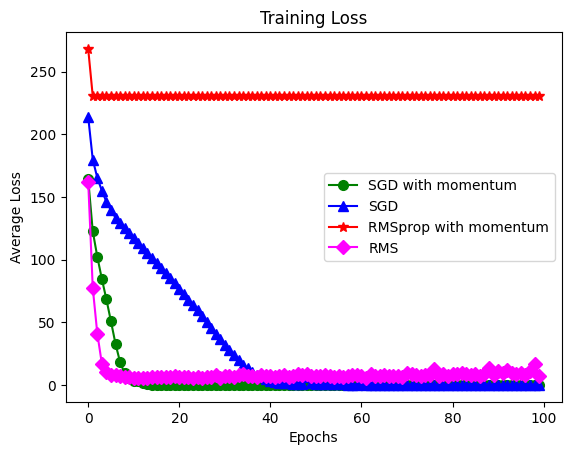

time: 1.09 s (started: 2024-03-21 09:53:36 +00:00)


In [ ]:
plt.plot(epoch_no,SGD_momen, label='SGD with momentum',color='green',marker='o',markersize=7)
plt.plot(epoch_no,SGD_, label='SGD',color='blue',marker='^',markersize=7)
plt.plot(epoch_no,RMS_momen, label='RMSprop with momentum',color='red',marker='*',markersize=7)
plt.plot(epoch_no,RMS_, label='RMS',color='magenta',marker='D',markersize=7)

plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Training Loss')
plt.legend()
plt.savefig('Training_Loss.png', bbox_inches='tight')
plt.show()


torch.save(model.state_dict(), "cifar10model.pth")

In [ ]:
import pandas as pd

df = pd.DataFrame()
df["epoch_no"]=epoch_no
df["SGD_momen"]=SGD_momen
df["SGD_"]=SGD_
df["RMS_momen"]=RMS_momen
df["RMS_"]=RMS_

df.to_csv('ReluLoss.csv')

time: 1.07 s (started: 2024-03-21 09:53:38 +00:00)
